In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os, gc
import warnings
warnings.filterwarnings("ignore")

In [0]:
from tqdm import tqdm
import pandas as pd
import numpy as np
tqdm.pandas()

In [0]:
!git clone https://github.com/ankishb/ml-projects.git

fatal: destination path 'ml-projects' already exists and is not an empty directory.


In [0]:
train = pd.read_csv('ml-projects/amazon-ml/Dataset/train.csv')
test  = pd.read_csv('ml-projects/amazon-ml/Dataset/test.csv')

train.columns = ['text','title','topic']
test.columns  = ['text','title']
train['text'].unique().shape, train['title'].unique().shape, train.shape


((4196,), (3727,), (5959, 3))

In [0]:
df = train.append(test, ignore_index=True)
df['text']  = df['text'].str.lower()
df['title'] = df['title'].str.lower()

In [0]:
import json
contract_file = 'ml-projects/amazon-ml/contraction_mapping.txt'
with open(contract_file) as f:
    contraction_mapping = json.loads(f.read())

In [0]:
def correct_contraction(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

df['text']  = df['text'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))
df['title'] = df['title'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))


100%|██████████| 8512/8512 [00:00<00:00, 115629.62it/s]


In [0]:
import os,operator

extra_punct = [
    ',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']


import string
my_punct = list(string.punctuation)
all_punct = list(set(my_punct + extra_punct))

special_punc_mappings = {"—": "-", "–": "-", "_": "-", '”': '"', "″": '"', '“': '"', '•': '.', '−': '-',
                         "’": "'", "‘": "'", "´": "'", "`": "'", '\u200b': ' ', '\xa0': ' ','،':'','„':'',
                         '…': ' ... ', '\ufeff': ''}

def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text

def clean_special_punctuations(text):
    for punc in special_punc_mappings:
        if punc in text:
#             print(punc)
            text = text.replace(punc, special_punc_mappings[punc])
    return text



def preprocess(text):
    text = spacing_punctuation(text)
    text = clean_special_punctuations(text)
    return text


df["text"] = df["text"].progress_apply(preprocess)
df['text'] = df['text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['text'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['text'].replace({'  ':' '}, regex=True, inplace=True)

df["title"] = df["title"].progress_apply(preprocess)
df['title'] = df['title'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['title'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['title'].replace({'  ':' '}, regex=True, inplace=True)


100%|██████████| 8512/8512 [00:00<00:00, 99091.89it/s]


In [0]:

import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text


def clean_text(x):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x


df['text']   = df['text'].progress_apply(clean_text)
df['title']  = df['title'].progress_apply(clean_text)

df['text'] = df['text'].progress_apply(clean_text)
df['title'] = df['title'].progress_apply(clean_text)

100%|██████████| 8512/8512 [00:00<00:00, 92911.31it/s]


In [0]:
import gc
tr_len = train.shape[0]
del train
gc.collect()
train = df[:tr_len]
train.shape

(5959, 3)

In [0]:
train['topic'] = train['topic'].apply(lambda x: "_".join(x.split(" ")))
gp = train.groupby(['text','title']).agg({
        "topic": lambda x: " ".join(x.values)
    })
train1 = pd.DataFrame(gp.reset_index())
train1.head()

,text,title,topic
0,300 mg of sodium per scoop serv...,way too much sodium per serving,Shipment_and_delivery
1,dont buy from here the vitamins are sp...,spoiled vitamins phony expiration date,Expiry
2,all finally got damn flavor right peach ma...,peach mango flavor is gooood,Bad_Taste/Flavor
3,arginine increases uric acid in the blood a...,do not take if you are prone to gout,Wrong_Product_received
4,arginine is supposed to be one of the safer...,good brand,Not_Effective


In [0]:
labels = train1['topic'].values

train['target'] = train['topic'].astype('category').cat.codes
train['target'] = train['target'].astype('int')

def get_mapping(df, col_name):
    cat_codes = df[col_name].astype('category')
    
    class_mapping = {}
    i = 0
    for col in cat_codes.cat.categories:
        class_mapping[col] = i
        i += 1
    
    class_mapping_reverse = {}
    for key, value in class_mapping.items():
        class_mapping_reverse[value] = key

    return class_mapping, class_mapping_reverse

cl_map, cl_map_inv = get_mapping(train, 'topic')

In [0]:
lt = np.zeros((train1.shape[0], 21))
j = -1
for key, value in cl_map.items():
    j += 1
    for i, label in enumerate(labels):
        if key in label.split(" "):
            lt[i][j] = 1

print(lt.sum(axis=0))        

[ 567. 1193.  233.    8.  239.   31.  135.   37.    6.   44.  215.  608.
  466.  107.  712.  387.  123.  410.   97.  228.   99.]


In [0]:
l_table = pd.DataFrame(data=lt, columns=list(cl_map.keys()))
l_table = l_table.astype('int')
l_table.head()

,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [0]:
train1.shape, l_table.shape

((4214, 3), (4214, 21))

In [0]:
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

def tfidf_feature(train, test, col_name, min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=120, decom_flag=False, which_method='svd', 
                  max_features=None, feat_col_name='svd'):

    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=1.0, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
#         return complete_df
#         print(complete_df.shape, complete_df.columns)

    tfv.fit(list(complete_df[:].values))

    if decom_flag is False:
        train_tfv =  tfv.transform(train[col_name].values.ravel()) 
        test_tfv  = tfv.transform(test[col_name].values.ravel())

        del complete_df
        gc.collect()
        return train_tfv, test_tfv, tfv
    else:
        complete_tfv = tfv.transform(complete_df[:].values.ravel())
        
        if which_method is 'svd':
            svd = TruncatedSVD(n_components=n_component)
            svd.fit(complete_tfv)
            complete_dec = svd.transform(complete_tfv)
        else:
            nmf = NMF(n_components=n_component, random_state=1234, alpha=0, l1_ratio=0)
            nmf.fit(complete_tfv)            
            complete_dec = nmf.fit_transform(complete_tfv)            
        
        
        complete_dec = pd.DataFrame(data=complete_dec)
        complete_dec.columns = [feat_col_name+'_'+str(i) for i in range(n_component)]

        train_dec = complete_dec.iloc[:train.shape[0]]
        test_dec = complete_dec.iloc[train.shape[0]:].reset_index(drop=True)

        del complete_dec, complete_df
        gc.collect()
        print("="*15, " done ", "="*15)
        return train_dec, test_dec, complete_tfv, tfv

def countvect_feature(train, test, col_name, min_df=3, 
                      analyzer='word', token_pattern=r'\w{1,}', 
                      ngram=3, stopwords='english', max_features=None):

    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
    ctv.fit(list(complete_df[:].values))

    train_tf =  ctv.transform(train[col_name].values.ravel()) 
    test_tf  = ctv.transform(test[col_name].values.ravel())

    del complete_df
    gc.collect()
    return train_tf, test_tf, ctv

class count:  [   0 2911  959  277   53   11    3]
class wise:   [ 567 1194  234    8  239   31  136   37    6   44  216  611  467  107
  715  390  123  410   97  228   99]


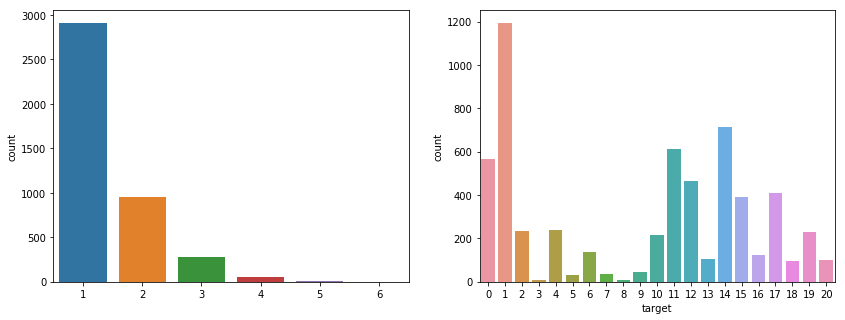

In [0]:
len1 = l_table.sum(axis=1)
# len2 = l_table.sum(axis=0)
fig, ax = plt.subplots(1,2,figsize=(14,5))
print("class count: ", np.bincount(len1))
print("class wise:  ", np.bincount(train['target']))

sns.countplot(len1, ax=ax[0])
sns.countplot(train['target'], ax=ax[1])


In [0]:
def get_count_vectorizer(df, col_name, min_df=3, analyzer='word', stopwords='english', 
                     token_pattern=r'\w{1,}', ngram=3, max_features=None):
    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    ctv.fit(list(df[col_name].values))

    df_new =  ctv.transform(df[col_name].values.ravel()) 
    return df_new


def get_tfidf_feature(df, col_name, min_df=3, analyzer='word', stopwords='english',
                  token_pattern=r'\w{1,}', ngram=3, max_features=None):

    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=1.0, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    tfv.fit(list(df[col_name].values))
    df_new =  tfv.transform(df[col_name].values.ravel()) 
    
    return df_new


In [0]:
count_vect_text = []
for ngram in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
#     if ngram < 11 : continue
    cvect = get_count_vectorizer(df, 'text', ngram)
    print(cvect.shape)
    count_vect_text.append(cvect)



(8512, 198403)
(8512, 98154)
(8512, 42302)
(8512, 18840)
(8512, 11203)
(8512, 7797)
(8512, 5610)
(8512, 4712)
(8512, 4074)
(8512, 3576)
(8512, 3209)
(8512, 2928)
(8512, 2693)
(8512, 2511)
(8512, 2312)


In [0]:
tfidf_text_store = []
for ngram in [1,2,3,4,5,6,7,8,9,10]:
    tfidf = get_tfidf_feature(df, 'text', ngram=ngram)
    print(tfidf.shape)
    tfidf_text_store.append(tfidf)

(8512, 5329)
(8512, 25168)
(8512, 42302)
(8512, 58359)
(8512, 73871)
(8512, 88889)
(8512, 103421)
(8512, 117475)
(8512, 131055)
(8512, 144168)


In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split    

for i, data in enumerate(tfidf_text_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

print("="*30)
for i, data in enumerate(count_vect_text):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

tfidf 0          acc: 0.3698
tfidf 1          acc: 0.3396
tfidf 2          acc: 0.3148
tfidf 3          acc: 0.3282
tfidf 4          acc: 0.3101
tfidf 5          acc: 0.3094
tfidf 6          acc: 0.3087
tfidf 7          acc: 0.2919
tfidf 8          acc: 0.3060
tfidf 9          acc: 0.2940
count-vect 0          acc: 0.3174
count-vect 1          acc: 0.3074
count-vect 2          acc: 0.3611
count-vect 3          acc: 0.3973
count-vect 4          acc: 0.4195
count-vect 5          acc: 0.4114
count-vect 6          acc: 0.4248
count-vect 7          acc: 0.4550
count-vect 8          acc: 0.4450
count-vect 9          acc: 0.4490
count-vect 10         acc: 0.4423
count-vect 11         acc: 0.4389
count-vect 12         acc: 0.4349
count-vect 13         acc: 0.4443
count-vect 14         acc: 0.4624


In [0]:
from sklearn.multiclass import OneVsRestClassifier as oneVsAll

for i, data in enumerate(count_vect_text):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = oneVsAll(MultinomialNB()).fit(X_train, Y_train)
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

ValueError: ignored

In [0]:
categories = list(data_raw.columns.values)
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))ax= sns.barplot(categories, data_raw.iloc[:,2:].sum().values)plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)#adding the text labels
rects = ax.patches
labels = data_raw.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)plt.show()

In [0]:
rowSums = data_raw.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]sns.set(font_scale = 2)
plt.figure(figsize=(15,8))ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')plt.show()

In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warningsdata = data_rawif not sys.warnoptions:
    warnings.simplefilter("ignore")def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantextdef cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaneddef keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sentdata['comment_text'] = data['comment_text'].str.lower()
data['comment_text'] = data['comment_text'].apply(cleanHtml)
data['comment_text'] = data['comment_text'].apply(cleanPunc)
data['comment_text'] = data['comment_text'].apply(keepAlpha)

    Next we remove all the stop-words present in the comments using the default set of stop-words that can be downloaded from NLTK library. We also add few stop-words to the standard list.
    Stop words are basically a set of commonly used words in any language, not just English. The reason why stop words are critical to many applications is that, if we remove the words that are very commonly used in a given language, we can focus on the important words instead.

stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)data['comment_text'] = data['comment_text'].apply(removeStopWords)

    Next we do stemming. There exist different kinds of stemming which basically transform words with roughly the same semantics to one standard form. For example, for amusing, amusement, and amused, the stem would be amus.

stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentencedata['comment_text'] = data['comment_text'].apply(stemming)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

In [0]:
# jeremy naive bayes


import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

It turns out that using TF-IDF gives even better priors than the binarized features used in the paper. I don't think this has been mentioned in any paper before, but it improves leaderboard score from 0.59 to 0.55.

n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])

test_term_doc = vec.transform(test[COMMENT])

This creates a sparse matrix with only a small number of non-zero elements (stored elements in the representation below).

trn_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775104 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765755 stored elements in Compressed Sparse Row format>)

Here's the basic naive bayes feature equation:

def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

x = trn_term_doc
test_x = test_term_doc

Fit a model for one dependent at a time:

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]



In [0]:
train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

scores = []
submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Total CV score is {}'.format(np.mean(scores)))

In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])